In [67]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.integrate import solve_ivp

# User Input
m_1 = 4
m_2 = 4
x_1 = [5.0,0.0]
x_2 = [-5.0,0.0]
v_1 = [5.0,0.0]
v_2 = [-5.0,0.0]
G = 1
t = 10

In [68]:
# Data Generation
def two_body_system(t, y):
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
  r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
  ax1 = G * m_2 * (x2 - x1) / r**3
  ay1 = G * m_2 * (y2 - y1) / r**3
  ax2 = G * m_1 * (x1 - x2) / r**3
  ay2 = G * m_1 * (y1 - y2) / r**3
  return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]

y0 = [x_1[0], x_1[1], x_2[0], x_2[1], v_1[0], v_1[1], v_2[0], v_2[1]]

t_span = [0, t*2]
t_points = np.linspace(0, t*2, 100)

ground_truth = solve_ivp(two_body_system, t_span, y0, t_eval=t_points, method='RK45')

t_data = t_points
x1_data = ground_truth.y[0]
y1_data = ground_truth.y[1]
x2_data = ground_truth.y[2]
y2_data = ground_truth.y[3]


index = int(0.8 * len(t_data))
t_train, t_test = t_data[:index], t_data[index:]
x1_train, x1_test = x1_data[:index], x1_data[index:]
y1_train, y1_test = y1_data[:index], y1_data[index:]
x2_train, x2_test = x2_data[:index], x2_data[index:]
y2_train, y2_test = y2_data[:index], y2_data[index:]

In [69]:
# Model Definition
class TwoBodyPINN(nn.Module):
    def __init__(self):
      super(TwoBodyPINN, self).__init__()
      self.fc1 = nn.Linear(1, 64)
      self.fc2 = nn.Linear(64, 128)
      self.fc3 = nn.Linear(128, 64)
      self.out = nn.Linear(64, 4)

    def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc3(x))
      x = self.out(x)
      return x

In [70]:
# Cost function consisting of three losses Data loss, Physics loss, Initial Value loss

def total_loss(model, t_train, x1_train, y1_train, x2_train, y2_train,lambda_data=10, lambda_phys=1.0, lambda_init=1.0):
  t_train_tensor = torch.tensor(t_train, dtype=torch.float32).reshape(-1,1)
  t_train_tensor.requires_grad_(True)

  # Predicted positions
  positions = model(t_train_tensor)
  x1 = positions[:, 0:1]
  y1 = positions[:, 1:2]
  x2 = positions[:, 2:3]
  y2 = positions[:, 3:4]

  # Velocities
  vx1 = torch.autograd.grad(x1.sum(), t_train_tensor, create_graph=True)[0]
  vy1 = torch.autograd.grad(y1.sum(), t_train_tensor, create_graph=True)[0]
  vx2 = torch.autograd.grad(x2.sum(), t_train_tensor, create_graph=True)[0]
  vy2 = torch.autograd.grad(y2.sum(), t_train_tensor, create_graph=True)[0]

  # Accelerations
  ax1 = torch.autograd.grad(vx1.sum(), t_train_tensor, create_graph=True)[0]
  ay1 = torch.autograd.grad(vy1.sum(), t_train_tensor, create_graph=True)[0]
  ax2 = torch.autograd.grad(vx2.sum(), t_train_tensor, create_graph=True)[0]
  ay2 = torch.autograd.grad(vy2.sum(), t_train_tensor, create_graph=True)[0]

  # Data Loss
  data_loss = torch.mean((x1 - torch.tensor(x1_train, dtype = torch.float32).reshape(-1,1))**2 +(y1 -torch.tensor(y1_train, dtype = torch.float32).reshape(-1,1))**2 +(x2 - torch.tensor(x2_train, dtype = torch.float32).reshape(-1,1))**2 +(y2- torch.tensor(y2_train, dtype = torch.float32).reshape(-1,1))**2)


  r = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2 + 1e-10)
  g_ax1 = G * m_2 *(x2 - x1) / r**3
  g_ay1 = G * m_2 *(y2 - y1) / r**3
  g_ax2 = G * m_1 *(x1 - x2) / r**3
  g_ay2 = G * m_1 *(y1 - y2) / r**3

  physics_loss = torch.mean((ax1 - g_ax1)**2 +(ay1 - g_ay1)**2 +(ax2 - g_ax2)**2 +(ay2 - g_ay2)**2)

  x1_0 = x1[0, 0]
  y1_0 = y1[0, 0]
  x2_0 = x2[0, 0]
  y2_0 = y2[0, 0]
  vx1_0 = vx1[0]
  vy1_0 = vy1[0]
  vx2_0 = vx2[0]
  vy2_0 = vy2[0]

  # Initial condition loss
  init_loss = ((x1_0 - x_1[0])**2 +(y1_0 - x_1[1])**2 +(x2_0 - x_2[0])**2 +(y2_0 - x_2[1])**2 +(vx1_0 - v_1[0])**2 +(vy1_0 - v_1[1])**2 +(vx2_0 - v_2[0])**2 +(vy2_0 - v_2[1])**2 )
  init_loss = torch.mean(init_loss)

  total = lambda_data * data_loss + lambda_phys * physics_loss + lambda_init * init_loss
  return total,{'data': data_loss.item(),'physics': physics_loss.item(), 'initial':init_loss.item()}


In [82]:
model = TwoBodyPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30000):
    optimizer.zero_grad()
    loss, loss_parts = total_loss(model, t_train, x1_train, y1_train, x2_train, y2_train,lambda_data=7.0, lambda_phys=1.0, lambda_init=1.0)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: total loss = {loss.item():.6f}, parts = {loss_parts}")

Epoch 0: total loss = 40689.171875, parts = {'data': 5065.39892578125, 'physics': 5132.10693359375, 'initial': 99.27311706542969}
Epoch 500: total loss = 10645.573242, parts = {'data': 1520.1590576171875, 'physics': 2.8504600524902344, 'initial': 1.6098018884658813}
Epoch 1000: total loss = 3323.554932, parts = {'data': 474.4949645996094, 'physics': 1.9343376159667969, 'initial': 0.15572509169578552}
Epoch 1500: total loss = 1111.773926, parts = {'data': 158.56138610839844, 'physics': 1.8376712799072266, 'initial': 0.006592887453734875}
Epoch 2000: total loss = 397.749969, parts = {'data': 56.562286376953125, 'physics': 1.8099113702774048, 'initial': 0.004047785419970751}
Epoch 2500: total loss = 151.696457, parts = {'data': 21.403841018676758, 'physics': 1.8667466640472412, 'initial': 0.0028291617054492235}
Epoch 3000: total loss = 61.659355, parts = {'data': 8.538063049316406, 'physics': 1.8903930187225342, 'initial': 0.0025209588930010796}
Epoch 3500: total loss = 26.928909, parts =

MAE: 15.67333
Mean ODE Residual: 2.45436


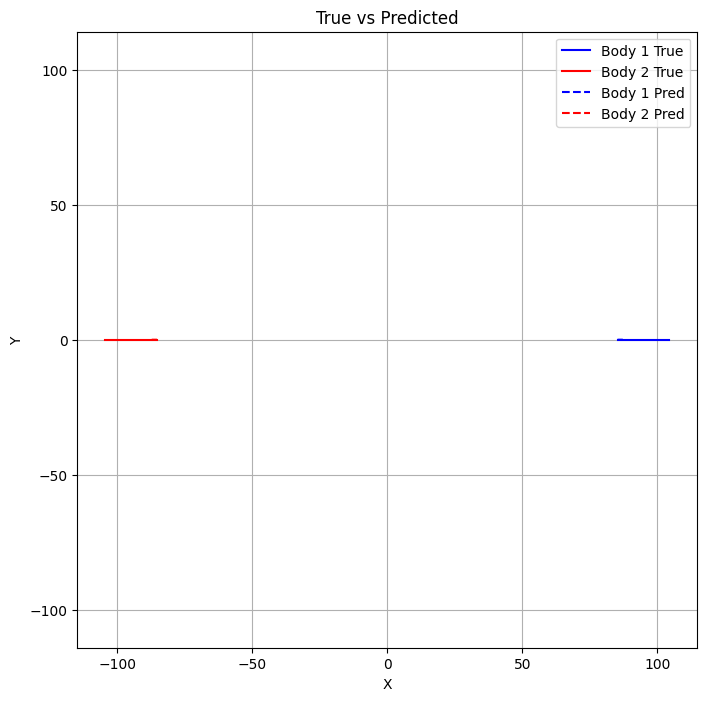

In [78]:
def model_eval(model,t_test):
  model.eval()
  t_test_tensor = torch.tensor(t_test, dtype=torch.float32).reshape(-1,1)
  t_test_tensor.requires_grad_(True)

  predictions = model(t_test_tensor)
  x1 = predictions[:, 0:1]
  y1 = predictions[:, 1:2]
  x2 = predictions[:, 2:3]
  y2 = predictions[:, 3:4]

  total_mae = torch.mean(torch.abs(x1 - torch.tensor(x1_test, dtype=torch.float32).reshape(-1,1)) + torch.abs(y1 - torch.tensor(y1_test, dtype=torch.float32).reshape(-1,1)) + torch.abs(x2 - torch.tensor(x2_test, dtype=torch.float32).reshape(-1,1)) + torch.abs(y2 - torch.tensor(y2_test, dtype=torch.float32).reshape(-1,1)))
  print(f"MAE: {total_mae:.5f}")

  vx1 = torch.autograd.grad(x1.sum(), t_test_tensor, create_graph=True)[0]
  vy1 = torch.autograd.grad(y1.sum(),t_test_tensor, create_graph=True)[0]
  vx2 = torch.autograd.grad(x2.sum(), t_test_tensor, create_graph=True)[0]
  vy2 = torch.autograd.grad(y2.sum(), t_test_tensor, create_graph=True)[0]

  ax1 = torch.autograd.grad(vx1.sum(), t_test_tensor, create_graph=True)[0]
  ay1 = torch.autograd.grad(vy1.sum(), t_test_tensor, create_graph=True)[0]
  ax2 = torch.autograd.grad(vx2.sum(),t_test_tensor, create_graph=True)[0]
  ay2 = torch.autograd.grad(vy2.sum(),t_test_tensor, create_graph=True)[0]

  r = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2 + 1e-10)

  g_ax1 = G*m_2*(x2 - x1)/ r**3
  g_ay1 = G*m_2*(y2 - y1)/ r**3
  g_ax2 = G*m_1*(x1 - x2)/ r**3
  g_ay2 = G*m_1*(y1 - y2)/ r**3

  residual_x1 = ax1 -g_ax1
  residual_y1 = ay1 -g_ay1
  residual_x2 = ax2 -g_ax2
  residual_y2 = ay2 -g_ay2

  mean_residual = torch.mean(torch.abs(residual_x1) + torch.abs(residual_y1) +torch.abs(residual_x2) + torch.abs(residual_y2)).item()

  print(f"Mean ODE Residual: {mean_residual:.5f}")

  # Plotting trajectory
  plt.figure(figsize=(8, 8))
  plt.plot(x1_test, y1_test, 'b-', label='Body 1 True')
  plt.plot(x2_test, y2_test, 'r-', label='Body 2 True')
  plt.plot(x1.detach().numpy().reshape(-1), y1.detach().numpy().reshape(-1), 'b--', label='Body 1 Pred')
  plt.plot(x2.detach().numpy().reshape(-1), y2.detach().numpy().reshape(-1), 'r--', label='Body 2 Pred')
  plt.legend()
  plt.title('True vs Predicted')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.axis('equal')
  plt.grid(True)
  plt.show()
  return total_mae, mean_residual


mae, residual = model_eval(model,t_test)




[-2.37770291 -2.42335213 -2.46901626 -2.51469495 -2.56038783 -2.60609455
 -2.6518148  -2.69754826 -2.74329462 -2.78905359 -2.8348249  -2.88060828
 -2.92640348 -2.97221026 -3.01802841 -3.0638577  -3.10969794 -3.15554895
 -3.20141055 -3.24728258]


array([1, 2, 3, 4])